In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_validation import KFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle


1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe



In [3]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert default and student to categorical variables.



In [4]:
df['default'] = df['default'].map({'Yes': 1, 'No': 0})
df['student'] = df['student'].map({'Yes': 1, 'No': 0})

df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.



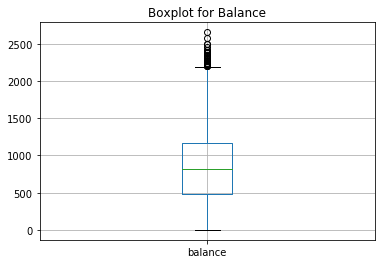

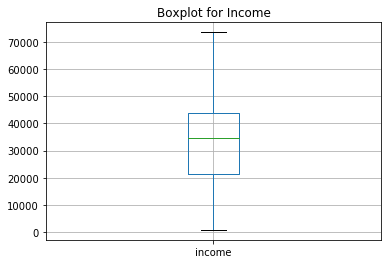

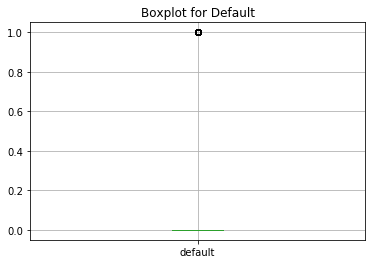

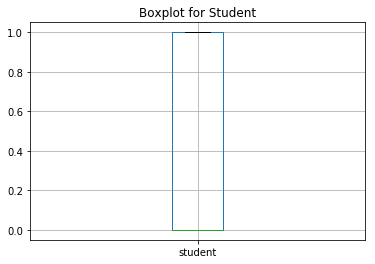

In [5]:
# Boxplots
df.boxplot(column='balance')
plt.title('Boxplot for Balance')
plt.show()

df.boxplot(column='income')
plt.title('Boxplot for Income')
plt.show()

df.boxplot(column='default')
plt.title('Boxplot for Default')
plt.show()

df.boxplot(column='student')
plt.title('Boxplot for Student')
plt.show()


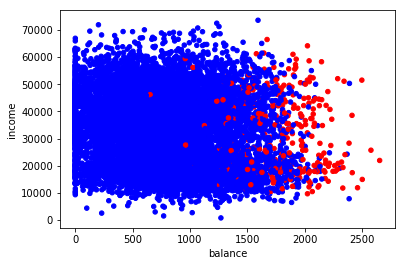

In [6]:
colors = np.where(df['default'] ==1, 'r', 'b')
df.plot(kind='scatter', x='balance', y='income',c=colors)
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.



The accuracy of this test is:  0.945670628183
[   0    1    2 ..., 2597 2598 2599]
[ 332764.52194859  332607.08441995  332449.64689131 ...,  -76100.73993344
  -76258.17746208  -76415.61499072]


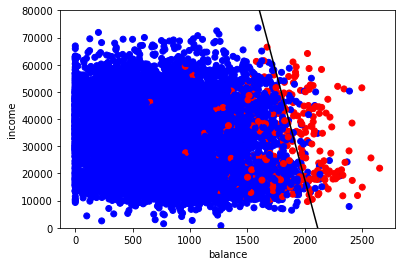

In [7]:
########## Train the model ##########

# Assign X and Y
student_only = df[df['student'] == 1]
X = student_only.loc[: , ['balance','income']]
y = student_only['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Train with training data
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

# Predict using test data
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('The accuracy of this test is: ', accuracy)

# Decision Boundary
coef = clf.coef_[0]
b = clf.intercept_
xx = np.arange(0,2600,1)
yy = (b + coef[0] * xx)/(-coef[1])


print(xx)
print(yy)

# Plot the result
plt.scatter(df['balance'], df['income'], c=colors)
plt.plot(xx, yy, 'black')
plt.xlabel('balance')
plt.ylabel('income')
plt.ylim(0,80000)
plt.show()



Area under the ROC curve :  0.935064243089


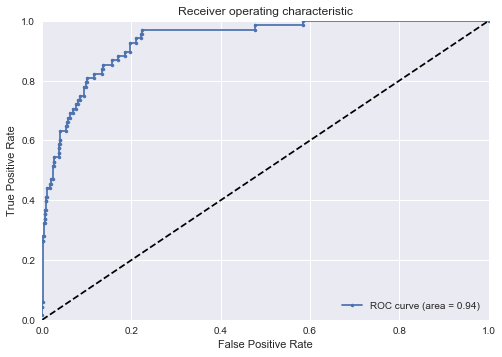

In [35]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,doprint=True,**kwargs):
    
    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    if doprint:
        print("Area under the ROC curve : ", roc_auc)
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?



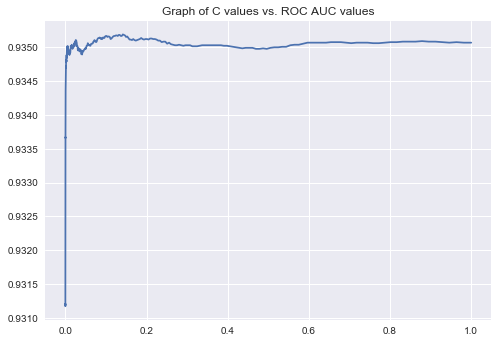

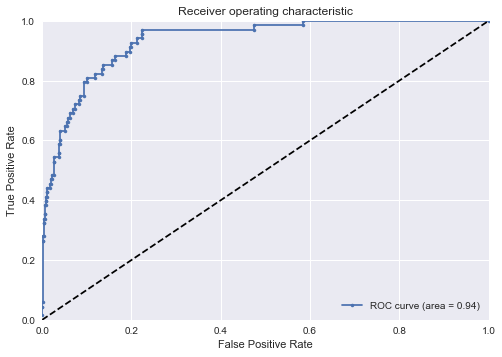

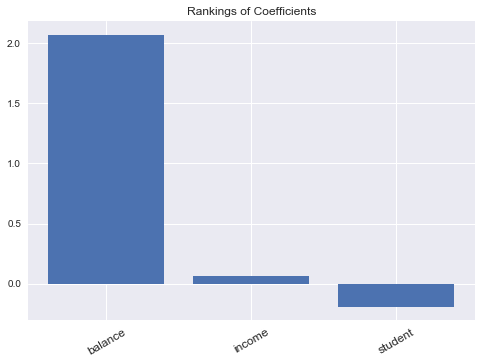

In [37]:
########## Train the model ##########

# Assign X and Y
X = df.loc[: , ['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Assign alphas
c_values = np.logspace(-8, 0, 1000)
scores = []
    
# Find optimal alpha
for c_value in c_values:
    fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,penalty='l2',C=c_value, doprint=False)
    scores.append(roc_auc)

# create a classifier with optimal c value
i_c_optim = np.argmax(scores)
c_optim = c_values[i_c_optim]

# Plot c values graph
plt.plot(c_values,scores)
plt.title('Graph of C values vs. ROC AUC values')
plt.show()

# Generate with optimal
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,penalty='l2',C=c_optim, doprint=False)

# Plot ROC curve
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Plot rankings of coefficients
labels = ['balance', 'income', 'student']
index = np.arange(len(labels))
plt.bar(index, clf.coef_[0])
plt.xticks(index, labels, fontsize=12, rotation=30)
plt.title('Rankings of Coefficients')
plt.show()




## Answer 5

It is hard to compare the two regressions because we are doing Lasso for one regression and Ridge for this regression. It looks like both logistic regressions give similar results for both AUC ROC, and accuracy. Looking at our coefficient weights, we can see that adding a student variable does not impact the default rate prediction that much. In fact, according to our coefficients, balance is the most important coefficient.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).



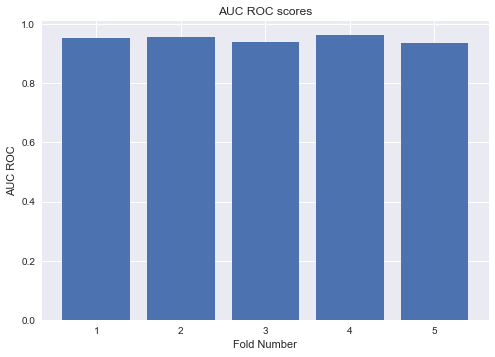

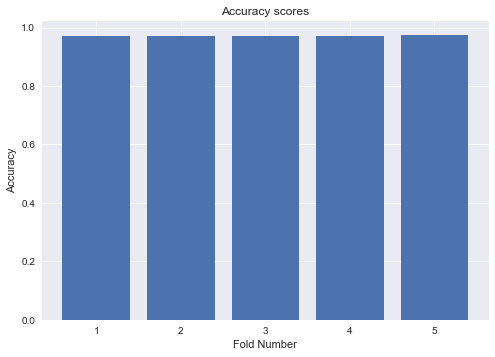

In [54]:
from sklearn.cross_validation import KFold
X = df.loc[: , ['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Compute the AUC ROC with the optimal coefficient on 5 folds
clf = LogisticRegression(C=c_optim,penalty='l2')

# AUC ROC Scores
auc_roc_log_regr = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
plt.bar(range(1,6),auc_roc_log_regr)
plt.title('AUC ROC scores')
plt.xlabel('Fold Number')
plt.ylabel('AUC ROC')
plt.show()
    
# Acuracy Scores
logistic_regr_scores = cross_val_score(clf, X, y, cv=5)
plt.bar(range(1,6),logistic_regr_scores)
plt.title('Accuracy scores')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.show()

### Answer 6)

As we can see from the scores above, the model gives good predictions for 5 fold cross-validation. Thus, our model is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?



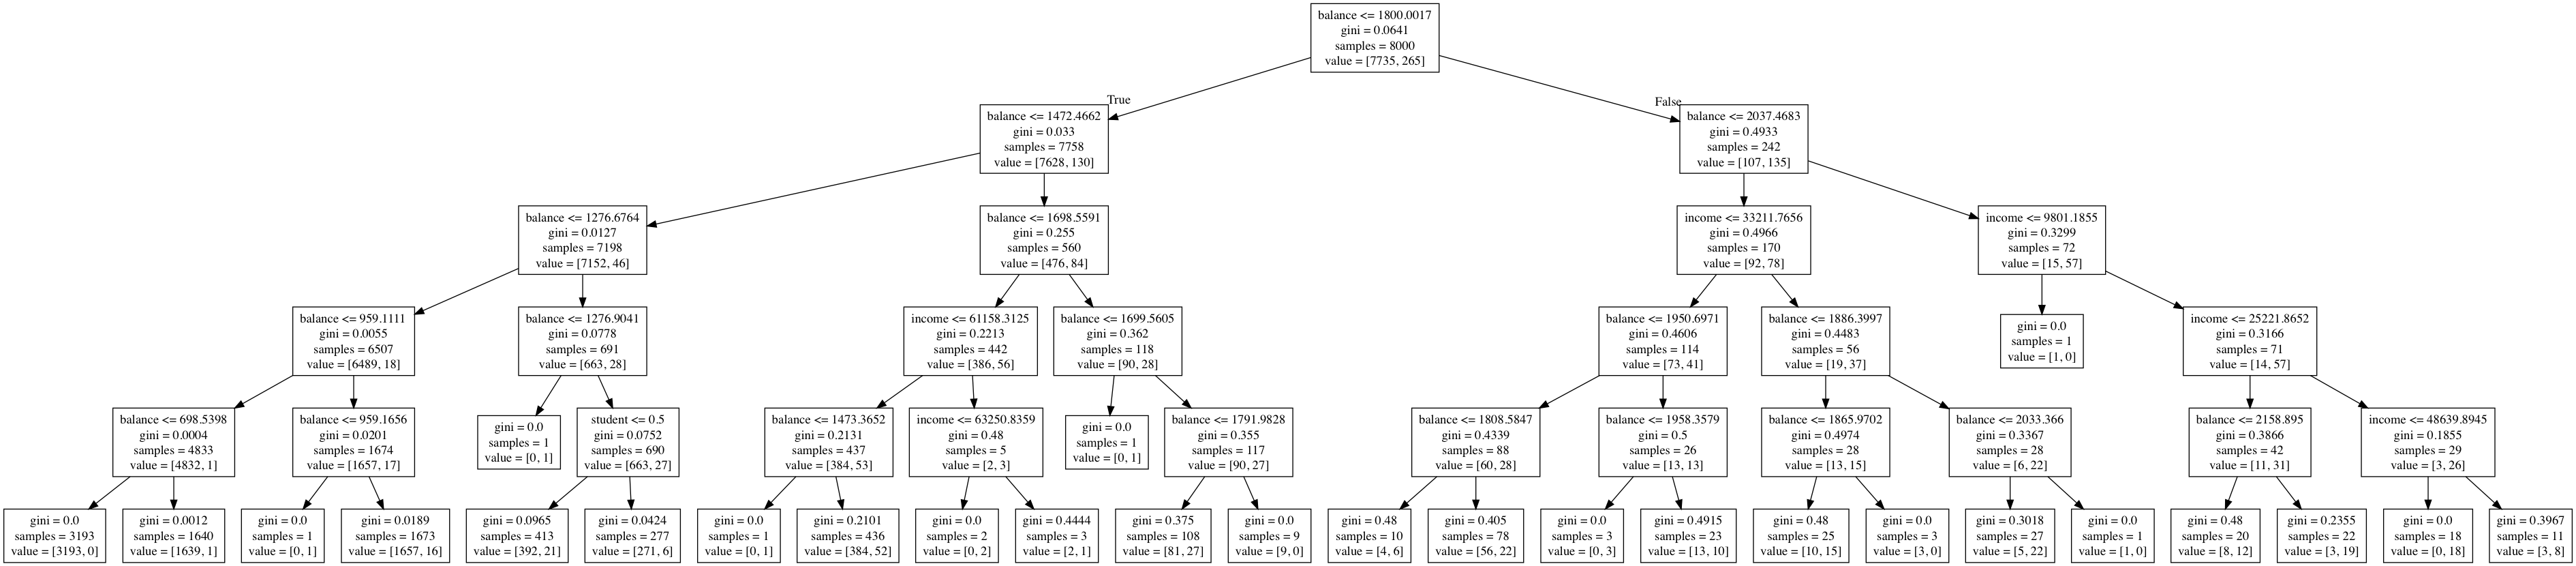

In [55]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import seaborn
import pydotplus


# Dataset
X = df.loc[: , ['balance','income','student']]
y = df['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Fit the decision tree
regr = DecisionTreeClassifier(max_depth=5)
regr.fit(X_train,y_train)

# Predict
y_pred = regr.predict(X_test)

dot_data = StringIO()  
export_graphviz(regr, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

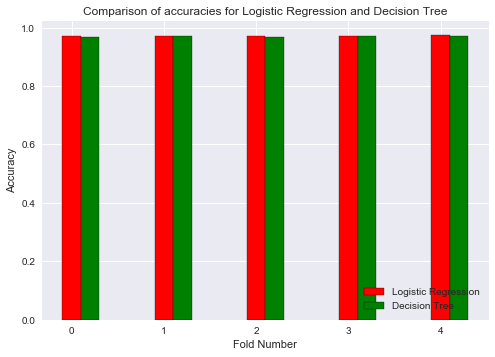

Mean Accuracy for Decision Trees:  0.97000029415
Mean Accuracy for Logistic Regression:  0.9722002945
Standard Deviation Accuracy for Decision Trees:  0.00216376155686
Standard Deviation Accuracy for Logistic Regression:  0.00120184386521


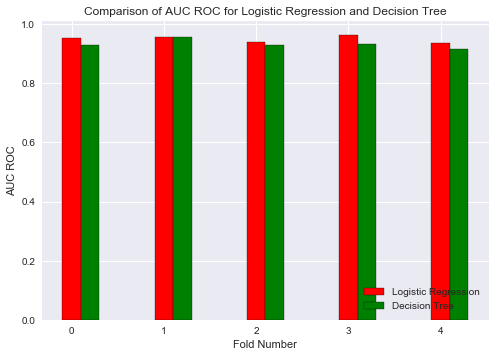

Mean AUC ROC for Decision Trees:  0.932824429585
Mean AUC ROC for Logistic Regression:  0.949627190758
Standard Deviation AUC ROC for Decision Trees:  0.013013232802
Standard Deviation AUC ROC for Logistic Regression:  0.0108668825937


In [56]:
X = df.loc[: , ['balance','income','student']]
y = df['default']

# Calculate decision tree scores
decision_tree_scores = cross_val_score(regr, X, y, cv=5)
decision_tree_auc_roc = cross_val_score(regr, X, y, cv=5, scoring='roc_auc')



# Plot the graph
barWidth = 0.2

r1 = np.arange(len(logistic_regr_scores))
r2 = [x + barWidth for x in r1]

plt.bar(r1, logistic_regr_scores, width = barWidth, color = 'red', edgecolor = 'black', label='Logistic Regression')
plt.bar(r2, decision_tree_scores, width = barWidth, color = 'green', edgecolor = 'black', label='Decision Tree')
plt.legend(loc=4)
plt.title('Comparison of accuracies for Logistic Regression and Decision Tree')
plt.ylabel('Accuracy')
plt.xlabel('Fold Number')
plt.show()

print('Mean Accuracy for Decision Trees: ', decision_tree_scores.mean())
print('Mean Accuracy for Logistic Regression: ', logistic_regr_scores.mean())
print('Standard Deviation Accuracy for Decision Trees: ', decision_tree_scores.std())
print('Standard Deviation Accuracy for Logistic Regression: ', logistic_regr_scores.std())

# Plot the graph
barWidth = 0.2

r1 = np.arange(len(logistic_regr_scores))
r2 = [x + barWidth for x in r1]

# Plot AUC ROC graph
plt.bar(r1, auc_roc_log_regr, width = barWidth, color = 'red', edgecolor = 'black', label='Logistic Regression')
plt.bar(r2, decision_tree_auc_roc, width = barWidth, color = 'green', edgecolor = 'black', label='Decision Tree')
plt.legend(loc=4)
plt.title('Comparison of AUC ROC for Logistic Regression and Decision Tree')
plt.ylabel('AUC ROC')
plt.xlabel('Fold Number')
plt.show()

print('Mean AUC ROC for Decision Trees: ', decision_tree_auc_roc.mean())
print('Mean AUC ROC for Logistic Regression: ', auc_roc_log_regr.mean())
print('Standard Deviation AUC ROC for Decision Trees: ', decision_tree_auc_roc.std())
print('Standard Deviation AUC ROC for Logistic Regression: ', auc_roc_log_regr.std())





### Answer 7)

It seems that overall both are good classifiers. However, the Logistic Regression has a higher mean accuracy and a smaller variance. In addition looking at the AUC ROC scores, we see that again, logistic regression is better. Thus, we would logistic regression is the better classifier.

8) Find the optimal decision tree depth and compute the AUC ROC.



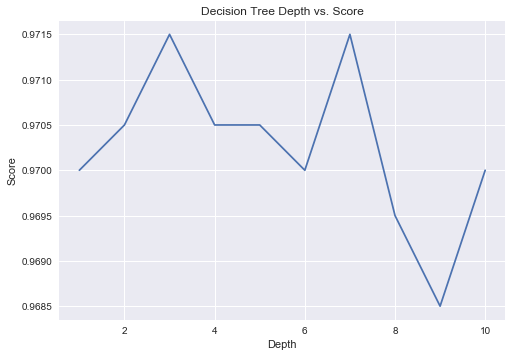

In [13]:
# Find optimal decision tree depth
X = df.loc[: , ['balance','income','student']]
y = df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Iterate through different depths
depths = range(1,11)
scores = []
for depth in depths:    
    regr = DecisionTreeClassifier(max_depth=depth)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))

# Plot graph of different depths
plt.plot(depths, scores)
plt.title('Decision Tree Depth vs. Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.show()
    

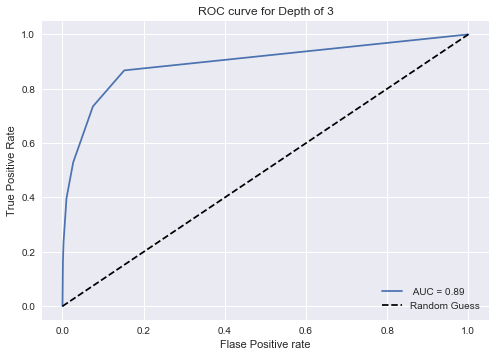

In [14]:
# Compute AUC ROC

# Dataset
X = df.loc[: , ['balance','income','student']]
y = df['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
# Fit the decision tree
tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(X_train, y_train)
predictions = tree.predict_proba(X_test)

# Calculate AUC ROC
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
roc_auc = auc(fpr, tpr)

# Plot
plt.plot(fpr, tpr, label = ' AUC = %.2f'%( roc_auc))
plt.xlabel('Flase Positive rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Depth of 3')
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Guess')
plt.legend(loc=4)
plt.show()


### Answer 8)

It seems that depth of 3 is giving the best accuracy. However, it is important to note that this is only for this train test split. From the graph, it seems that depths from 3 - 7 are all reasonably good depths.